In [304]:
import pandas as pd

from core.fs import FsLoader
from core.repository.maria.conn import maria_home
from utils.timeutil import YearMonth
from utils.timeutil import YearQtr

begin = YearMonth(2014, 4)
end = YearMonth(2023, 12)

# 월 차트 로드
print("Fetching month chart...")
month_chart = pd.read_sql(
    f"""
    select month_chart.* from month_chart
    where year(date) >= {begin.year}
    """,
    maria_home()
)

# 재무제표 로드
print("Loading financial data...")
fs_loader = FsLoader()

month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
layer1 = pd.DataFrame()
yms = list(begin.to(end))
yms = pd.Series(yms)
yms = yms.drop_duplicates().sort_values()

print("Making layer1...")
for ym1, ym2 in [(ym.iloc[0], ym.iloc[1]) for ym in yms.rolling(2) if len(ym) == 2]:
    print(f"\r{ym1} {ym2}", end="\r")
    df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
    df1 = df1[df1["date"] == df1["date"].max()]  # date = date.max 아니면, 상장폐지 되는 종목. 매수일이 월말이기 때문에 매수 불가
    df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
    df2["date"] = df2["date"].max()  # date = date.max 아니면, 상장폐지 되는 종목. 정리매매 거치기 때문에 별도 처리 필요 없음.
    df1 = df1[df1["open"] > 0]  # 시가=0 은 거래정지, 따라서 매수불가
    df1 = df1[df1["val_last"] > 1_000_0000]  # 거래량 일정 수준 이상(거래량 적을 시 매수 실패할거라고 가정)
    df2["close"] = df2["close"].astype(float)
    df2.loc[(df2["open"] == 0), "close"] /= 2  # 거래정지 시 투자금이 1/2 된다고 가정

    df = pd.DataFrame({
        "매수년월": ym1,
        "매도년월": ym2,
        "종목명": df1["name"],
        "매수일": df1["date"],
        "매수가": df1["close"],
        "P": df1["cap"],
        "vol": df1["vol"],
        "val": df1["val"],
        "shares": df1["shares"],
        "avg": df1["avg"],
        "전월수익률": df1["close"] / df1["open"] - 1,
        "매도가": df2["close"],
        "매도일": df2["date"]
    }).reindex(df1.index)

    shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
    df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거
    df.loc[df["매도가"].isna(), "매도가"] = 0
    df["수익률"] = df["매도가"] / df["매수가"] - 1

    settled_qtr = YearQtr.settled_of(ym1.last_date)
    fn = fs_loader.load(settled_qtr.year, settled_qtr.qtr)
    layer1 = pd.concat([layer1, df.join(fn)])

layer1.reset_index(inplace=True)
layer1.to_csv(".cache/layer1.csv", index=False)

Fetching month chart...
Loading financial data...
Making layer1...


In [305]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from utils.timeutil import YearMonth

layer1 = pd.read_csv(".cache/layer1.csv", dtype={"code": str})
layer1["매수년월"] = layer1["매수년월"].apply(lambda x: YearMonth.from_string(x))
layer1["매도년월"] = layer1["매도년월"].apply(lambda x: YearMonth.from_string(x))

font_path = '../res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

layer1 = layer1[layer1["확정실적"].notna()]
layer1.shape

(207613, 55)

In [312]:
import numpy as np

layer2 = layer1.copy()


def add_factor(name, value):
    factors.append(name)
    layer2[name] = value


factors = ["P", "수익률", "val"]
factors += [col for col in layer1.columns if col.endswith("QoQ")]

add_factor("logP", np.ceil(np.log2(layer2["P"])))

# 가격비율
add_factor("EQ/P", layer2["EQ"] / layer2["P"])

is_cols = ["R", "GP", "O", "EBT", "E"]
for col in is_cols:
    add_factor(f"{col}/P", layer2[f"{col}/Y"] / layer2["P"])
    add_factor(f"{col}/A", layer2[f"{col}/Y"] / layer2["A"])  # 자산비율
    add_factor(f"{col}/EQ", layer2[f"{col}/Y"] / layer2["EQ"])  # 자본비율
    if col != "R":
        add_factor(f"{col}/R", layer2[f"{col}/Y"] / layer2["R/Y"])  # 이익율

add_factor("유동부채비율", layer1["유동부채"] / layer1["유동자산"])

# RECIPE ==========================================================

recipes = {
    "벨류": {
        "GP/P": 0.120550,
        "EQ/P": 0.105678,
    },
    "퀄리티": {
        "GP/A": 0.032862,
        "GP/EQ": 0.028487,
        "R/A": 0.012971,
        "GP/R": 0.012141,
        "O/A": 0.009835,
        "E/R": 0.005616,
        "EBT/A": 0.005415,
        "O/EQ": 0.005188,
        "O/R": 0.004577,
        "R/EQ": 0.004484,
        "EBT/R": 0.003881,
        "E/A": 0.003815,
        "EBT/EQ": 0.003162,
        "E/EQ": 0.002940
    },
    "성장": {
        "O_QoQ": 0.027,
        "E_QoQ": 0.024,
        "EBT_QoQ": 0.017,
        "O/A_QoQ": 0.013,
        "E/EQ_QoQ": 0.011,
        "O/EQ_QoQ": 0.01,
        "E/A_QoQ": 0.009,
        "EBT/A_QoQ": 0.008,
        "EBT/EQ_QoQ": 0.006,
        "GP/EQ_QoQ": 0.004,
        "GP/A_QoQ": 0.004,
        "GP_QoQ": 0.003,
        "R_QoQ": 0.001,
        "R/EQ_QoQ": 0.001,
        "R/A_QoQ": 0.001,
    },
    "가격": {
        "P": -1
    },
    "전략": {
        "성장": 1,
        "벨류": 1,
        "가격": 1
    },
}

# for k1 in ["R", "GP", "O", "EBT", "E"]:
#     recipes[k1 + "성장"] = {
#         k1 + k2 + "_QoQ": 1 for k2 in ["", "/A", "/EQ"]
#     }
# 
# for k1 in ["_QoQ", "/A_QoQ", "/EQ_QoQ"]:
#     recipes[k1 + "성장"] = {
#         k2 + k1: 1 for k2 in ["R", "GP", "O", "EBT", "E"]
#     }
# 
# recipes["신성장"] = {
#     "_QoQ성장": 1,
#     "O성장": 1
# }

# =================================================================

pct_scale = 20


def calc_pct_by_month(_col: str):
    grouped_by_month = layer2.groupby("매도년월")[_col]
    return grouped_by_month.apply(lambda x: np.ceil(x.rank(pct=True) * pct_scale)).reset_index(level=0, drop=True)


for factor in factors:
    layer2[f"{factor}_pct"] = calc_pct_by_month(factor)

for title, recipe in recipes.items():
    layer2[title] = layer2.apply(lambda row: sum([row[f"{k}_pct"] * w for k, w in recipe.items()]), axis=1)
    layer2[f"{title}_pct"] = calc_pct_by_month(title)

layer2.shape

(207613, 113)

In [313]:
import matplotlib.pyplot as plt

factor = "전략"

returns = layer2.groupby(factor + "_pct").apply(lambda x: x.groupby("매도년월")["수익률"].mean())
if type(returns) is pd.Series:
    returns = returns.to_frame().reset_index().pivot(index=factor + "_pct", columns="매도년월")
    returns = returns.droplevel(level=0, axis=1)

years = returns.columns.min().duration(returns.columns.max())
cagr_by_rank = returns.apply(lambda x: (x + 1).prod() ** (1 / years) - 1, axis=1)
corr_by_month = returns.apply(lambda x: x.corr(pd.Series(x.index)))

# plt.figure(figsize=(10, 6))
# plt.bar([str(month) for month in corr_by_month.index], corr_by_month.values)
# plt.xticks([str(x) for x in corr_by_month.index[::len(corr_by_month) // 8]])

(returns + 1).cumprod(axis=1)

매도년월,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,...,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
전략_pct,,,,,,,,,,,,,,,,,,,,,
1.0,0.970437,0.952827,0.931807,0.945422,0.916694,0.873165,0.880470,0.841849,0.885565,0.931599,...,0.485505,0.460698,0.460615,0.448061,0.481053,0.475123,0.432526,0.374188,0.424068,0.438686
2.0,1.002483,0.967786,0.992098,1.023151,1.013848,0.980588,0.984414,0.965244,1.002234,1.042242,...,0.702159,0.664007,0.680807,0.666006,0.672429,0.678067,0.616126,0.531452,0.609279,0.631649
3.0,0.971603,0.974017,0.985809,1.031631,1.039100,1.009530,0.974128,0.949267,1.006428,1.044681,...,0.717861,0.730828,0.751167,0.764873,0.780199,0.766152,0.702325,0.617048,0.669245,0.713168
4.0,0.956309,0.981986,1.012239,1.050131,1.096349,1.072236,1.015610,0.991754,1.031876,1.123500,...,1.170941,1.162149,1.186322,1.227176,1.217510,1.205916,1.119456,0.997612,1.100966,1.123358
5.0,0.971611,0.941954,0.915083,0.954615,0.923819,0.893178,0.893566,0.901465,0.957783,0.959230,...,0.986609,1.000225,1.011825,1.027056,0.978362,1.016245,0.946413,0.871636,0.955664,0.987671
6.0,0.982800,0.970047,0.998937,1.017064,1.037989,1.031982,1.035117,1.034026,1.087651,1.160399,...,1.471174,1.438939,1.468712,1.471191,1.438411,1.503685,1.406873,1.299852,1.448404,1.499226
7.0,0.976383,0.950835,0.979342,1.020128,1.024891,0.991211,0.980909,1.017807,1.072756,1.149573,...,1.286206,1.251770,1.317171,1.339631,1.307474,1.334776,1.262176,1.107654,1.193333,1.249617
8.0,0.985205,0.963820,0.944710,1.027222,1.053769,1.024125,1.007036,0.983205,1.086855,1.147514,...,1.775974,1.690925,1.737052,1.757474,1.722643,1.761770,1.673826,1.512138,1.610305,1.633519
9.0,1.011807,1.008620,1.043887,1.077456,1.075812,1.018144,0.967732,0.994521,1.049056,1.100896,...,1.620711,1.624791,1.671457,1.680989,1.618519,1.648380,1.593075,1.469994,1.569039,1.613936


[2/2] E/A2014-04 2023-12


,strength,slope,spearman,pearson,t10,h10,t10-h10,mean,median
E/A,0.085005,-0.189693,-0.448120,-0.543950,0.084035,0.104832,-0.020797,0.094433,0.092705
E/P,0.003035,-0.041190,-0.073684,-0.092002,0.098912,0.089695,0.009218,0.094304,0.097945


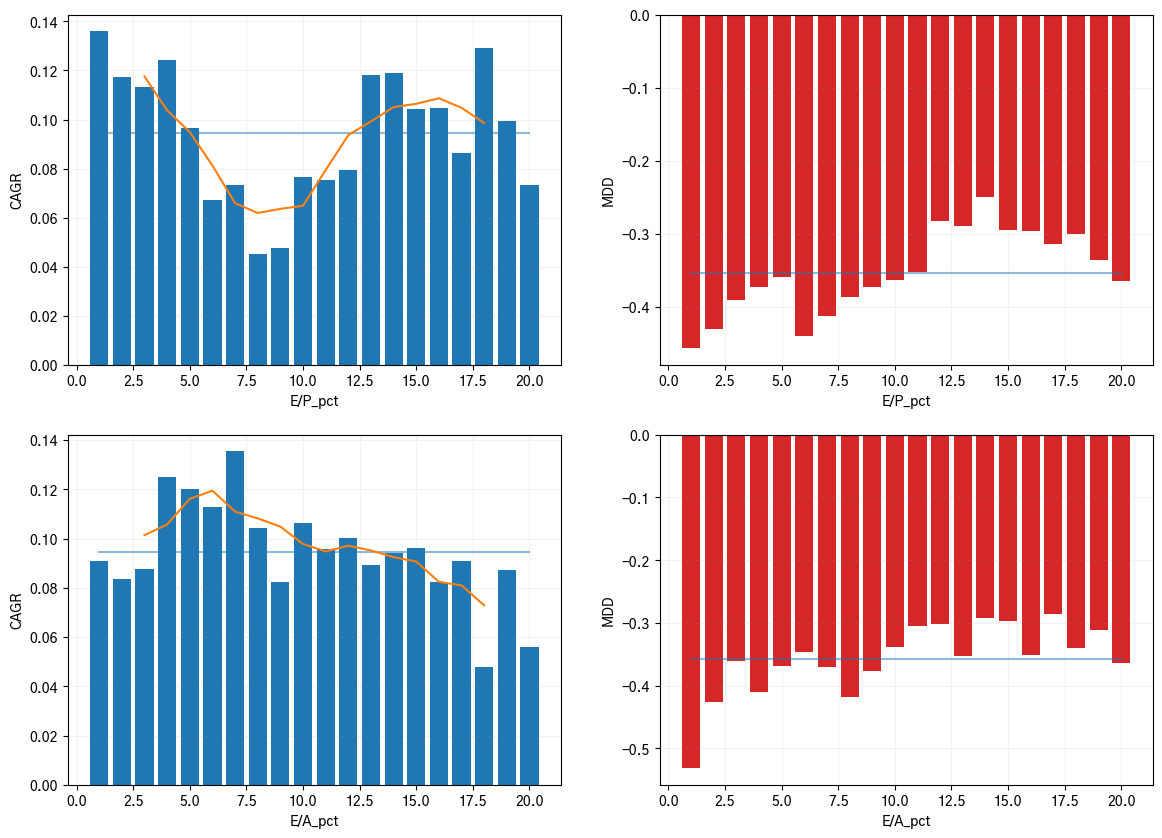

In [314]:
import matplotlib.pyplot as plt
from utils.quantutil import cagr as calc_cagr
from utils.quantutil import mdd as calc_mdd
from utils import pdutil

# target_factors = list(recipes.keys())
target_factors = ["E/P", "E/A"]

fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(14), fig.set_figheight(5 * len(target_factors))
summary = pd.DataFrame()

# 다시.. 그리고..
# mdd
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname = f"{factor}_pct"
    pcts = layer2[colname].dropna().sort_values().unique()
    cagr, mdd = [], []
    for pct in pcts:
        by_pct = layer2[layer2[colname] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        cumprod = (return_by_ym + 1).cumprod()
        cagr.append(calc_cagr(1, cumprod.iloc[-1], by_pct["매수년월"].min().duration(by_pct["매도년월"].max())))
        dates = [s.last_date for s in return_by_ym.index]
        mdd.append(calc_mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]
    pcts = pd.Series(pcts)
    cagr, mdd = pd.Series(cagr), pd.Series(mdd)

    ax1.set_xlabel(colname)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(pd.Series(pcts), cagr, color=["tab:blue" if v > 0 else "tab:red" for v in cagr])
    ax1.plot(pd.Series(pcts), [cagr.mean() for _ in pd.Series(pcts)], alpha=0.5)
    ax1.plot(pd.Series(pcts), cagr.rolling(5, center=True).mean())

    ax2.set_xlabel(colname)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(pd.Series(pcts), mdd, color=["tab:blue" if v > 0 else "tab:red" for v in mdd])
    ax2.plot(pd.Series(pcts), [mdd.mean() for _ in pd.Series(pcts)], alpha=0.5)

    pct_mean = pcts.mean()
    cagr_mean = cagr.mean()

    slope = sum((pcts - pct_mean) * (cagr * 100 - cagr_mean)) / sum((pcts - pct_mean) ** 2)
    spearman = pd.DataFrame({colname: pcts, "CAGR": cagr}).corr(method="spearman")
    pearson = pd.DataFrame({colname: pcts, "CAGR": cagr}).corr()
    summary = pd.concat([
        summary,
        pd.Series({
            "slope": slope,
            "spearman": spearman[colname]["CAGR"],
            "pearson": pearson[colname]["CAGR"],
            "t10": cagr.tail(10).mean(),
            "h10": cagr.head(10).mean(),
            "t10-h10": cagr.tail(10).mean() - cagr.head(10).mean(),
            "mean": cagr.mean(),
            "median": cagr.median(),
        }).to_frame(factor).T
    ])
    summary["strength"] = summary["spearman"] * summary["slope"]

print(layer2["매수년월"].min(), layer2["매도년월"].max())
summary = summary.sort_values(by="strength", ascending=False)
summary = summary[pdutil.sort_columns(summary.columns, forward=["strength"])]
summary.to_csv(".cache/summary.csv")
summary

In [315]:
# 백테스트

from utils.quantutil import cagr, mdd

_key = ["매수년월", "매도년월"]
benchmark = layer2.groupby(_key)["수익률"].mean()

strategy_name = "전략"
print(strategy_name)

result2 = layer2.copy()[layer2[strategy_name].notna()]

result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/R_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/R_pct"] > 10]
result2 = result2[result2["EBT/A_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["O/R_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["EBT/R_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["EBT/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

port_size = 20
port = result2.groupby(_key).apply(lambda x: x.sort_values(strategy_name, ascending=False).head(port_size))
strategy = port.reset_index(drop=True).groupby(_key)["수익률"].mean()
strategy = pd.Series(strategy, index=benchmark.index)

revisions = pd.DataFrame({
    "BM 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": strategy - benchmark,
    "BM 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod(),
})

running_max = revisions["BM 누적수익률"].cummax()
revisions["BM DD"] = (revisions["BM 누적수익률"] - running_max) / running_max

running_max = revisions["전략 누적수익률"].cummax()
revisions["전략 DD"] = (revisions["전략 누적수익률"] - running_max) / running_max

revisions = revisions.dropna()

years = len(revisions) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"].iloc[-1], years), cagr(1, revisions["BM 누적수익률"].iloc[-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions["전략 누적수익률"].index], revisions["전략 누적수익률"].tolist()),
            mdd([i2 for _, i2 in revisions.index], revisions["BM 누적수익률"].tolist())],
    "Mean": [revisions["전략 수익률"].mean(), revisions["BM 수익률"].mean()]
}, index=["전략", "BM"])
print(summary)

revisions.to_csv(".cache/revisions.csv")
revisions

전략
        CAGR                                        MDD      Mean
전략  0.239738  (-0.2786399217210592, (2022-03, 2022-09))  0.020470
BM  0.092621  (-0.3236838585927504, (2018-05, 2020-03))  0.009268


,,BM 수익률,전략 수익률,성능,BM 누적수익률,전략 누적수익률,BM DD,전략 DD
매수년월,매도년월,,,,,,,
2014-04,2014-05,-0.001313,0.028122,0.029435,0.998687,1.028122,0.000000,0.000000
2014-05,2014-06,-0.008577,0.007299,0.015876,0.990121,1.035626,-0.008577,0.000000
2014-06,2014-07,0.019002,0.007919,-0.011083,1.008935,1.043827,0.000000,0.000000
2014-07,2014-08,0.039388,0.001990,-0.037398,1.048675,1.045905,0.000000,0.000000
2014-08,2014-09,0.011842,0.045231,0.033388,1.061094,1.093212,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2023-07,2023-08,0.019210,0.023923,0.004713,2.434077,8.009410,-0.179785,-0.027897
2023-08,2023-09,-0.058858,-0.012830,0.046027,2.290813,7.906646,-0.228061,-0.040369
2023-09,2023-10,-0.084423,-0.000082,0.084341,2.097414,7.905997,-0.293231,-0.040448


In [316]:
result3 = port.reset_index(drop=True).groupby(_key).apply(lambda x: x.sort_values("수익률", ascending=False))[[
    "code", "종목명", "수익률", "매수일", "매도일", "매수가", "매도가", "consolidated", f"{strategy_name}_pct"
]]
result3 = result3.reset_index(drop=True)
result3.to_csv(".cache/port.csv")
result3

,code,종목명,수익률,매수일,매도일,매수가,매도가,consolidated,전략_pct
0,011390,부산산업,0.328386,2014-04-30,2014-05-30,26950.0,35800.0,1.0,20.0
1,003850,보령제약,0.236364,2014-04-30,2014-05-30,38500.0,47600.0,0.0,13.0
2,016450,한세예스24홀딩스,0.187143,2014-04-30,2014-05-30,7000.0,8310.0,1.0,16.0
3,079370,제우스,0.119565,2014-04-30,2014-05-30,13800.0,15450.0,1.0,18.0
4,093520,매커스,0.037267,2014-04-30,2014-05-30,2415.0,2505.0,1.0,13.0
...,...,...,...,...,...,...,...,...,...
2315,005990,매일홀딩스,-0.045667,2023-11-30,2023-12-28,8540.0,8150.0,1.0,19.0
2316,000320,노루홀딩스,-0.048173,2023-11-30,2023-12-28,12040.0,11460.0,1.0,19.0
2317,005740,크라운해태홀딩스,-0.052373,2023-11-30,2023-12-28,6110.0,5790.0,1.0,20.0
2318,007210,벽산,-0.062500,2023-11-30,2023-12-28,2800.0,2625.0,1.0,18.0


total            116.000000
out-perform       55.000000
under-perform     30.000000
승률                 0.603448
누적 성능              2.389062
dtype: float64

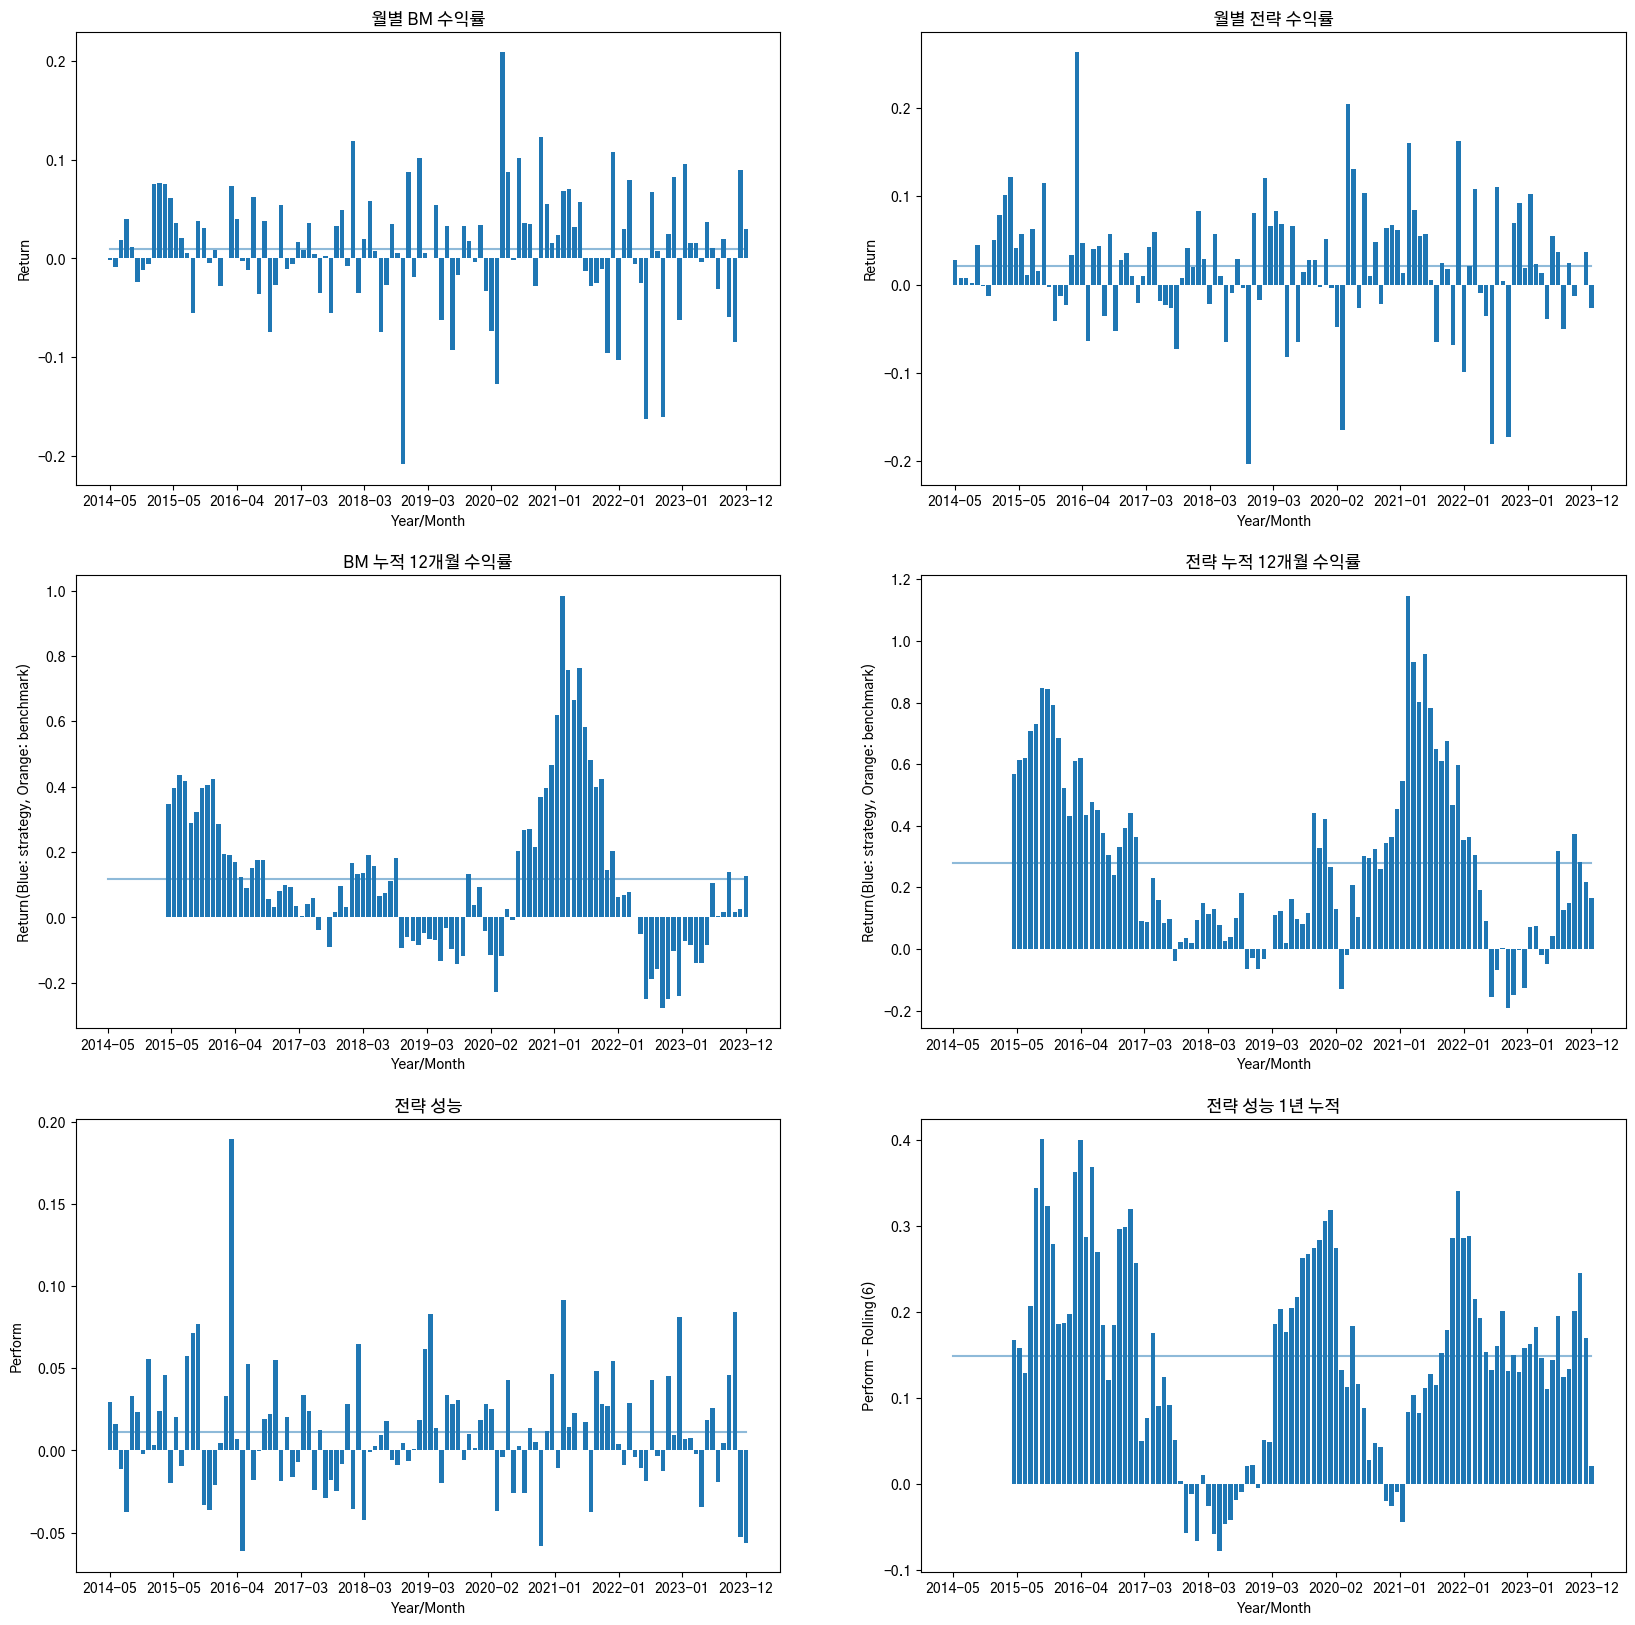

In [317]:
import numpy as np

months = [str(i) for _, i in revisions.index]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 BM 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["BM 수익률"])
ax1.plot(months, [revisions["BM 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"BM 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["BM 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "total": len(revisions),
    "out-perform": (revisions["성능"] > 0.01).sum(),
    "under-perform": (revisions["성능"] < -0.01).sum(),
    "승률": (revisions["성능"] > 0).sum() / len(revisions),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})

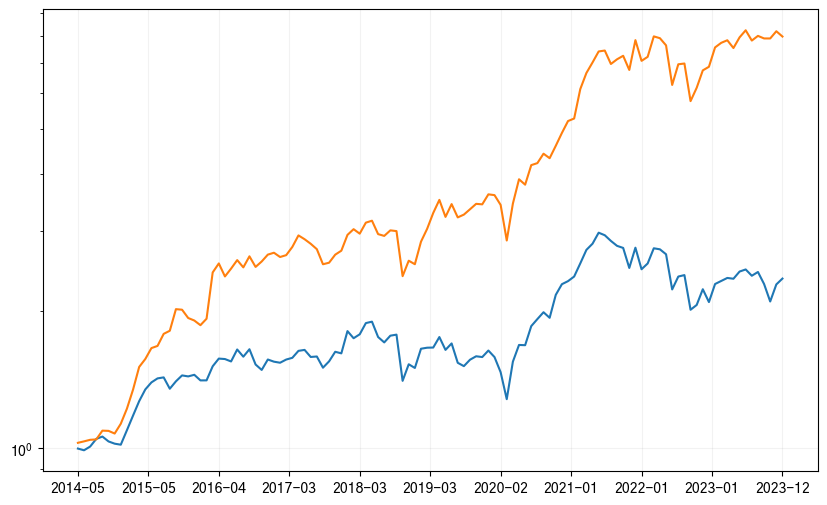

In [318]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 예시 생성
plt.figure(figsize=(10, 6))
plt.plot(months, revisions["BM 누적수익률"])
plt.plot(months, revisions["전략 누적수익률"])

plt.yscale('log')
plt.xticks(np.quantile(np.arange(0, len(revisions)), xticks))
plt.grid(True)